In [1]:
import pickle as pkl
A = pkl.load(open('./brain_one_adj.pkl','rb'))


In [2]:
A

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [3]:
import jax.numpy as np

import numpy as onp

from jax import random

from jax import grad, jit, vmap

import matplotlib.pylab as plt



In [4]:
from tqdm.notebook import trange

# #usual installation 
# pip install ipywidgets 
# jupyter nbextension enable --py widgetsnbextension
# jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [5]:
A_ini = A.copy()

In [6]:
A_ini[A==1]= 0.9
A_ini[A==0]= 0.1

phi = np.log(A_ini/(1-A_ini))

In [7]:
def sigmoid(x):
    return 1.0/(1.0+ np.exp(-x))

def softplus(x):
    return np.log(1.0+ np.exp(x))



In [8]:

phi -= np.mean(phi)

Q, D, _ =np.linalg.svd(phi)

n = A.shape[0]
k = 5

B = onp.random.normal(0,1,[n,k])

p = onp.random.uniform(0,1,k)

a = onp.ones(k)
b = onp.random.normal(0,1,k)



D= (D[:k])

z = -5.0

In [9]:
def llh(A, Q, D, z):
    #D: k diagonal matrix
    #Q: n*k matrix
    pi_0 = Q@np.diag(np.abs(D))@Q.T
    
    pi = sigmoid(pi_0 + z)
    loglh = A* np.log(pi)+(1-A)*np.log(1.0-pi)
    s = np.sum(np.tril(loglh,k=-1))
    return(s)

In [10]:
# import jax.scipy.special
def prior_D(D):
    a= .1
    b= .1
    return np.sum( -(a+1)* np.log(D) - b/D)

def prior_Z(z):
    return - z**2/2.0/3**2

In [11]:
def g(W, p):
    return np.sum(W@np.log(p) + (1.0 -W) @ np.log(1.0 -p))

In [12]:
def U(D, B, z, a, b, p):
    #D: k-dim vector
    n,k = B.shape
    
    tau = 1E-2
    
    W = 1/(1+np.exp(-B/tau))
    
    X = W @ np.diag(a) + (1.0-W)@ np.diag(b)

    Mx = X.T@X
    cholL = np.linalg.cholesky(Mx)
    Q= np.linalg.solve(cholL, X.T).T
    
    u = -llh(A, Q, D, z) - prior_D(np.abs(D)) - prior_Z(z) - g(W, p)  - (n-k-1)/2.0*(np.linalg.slogdet(Mx)[1]) +  (np.sum(a**2 + b**2))/2.0

    return(u)

In [13]:
U_fast = jit(U)

In [14]:
U_fast(D,B,z,a,b,p)

DeviceArray(2992.3223, dtype=float32)

In [15]:
grad_U = jit(grad(U, (0,1,2)))

In [16]:
epsilon = 1E-3

In [17]:
def HMC(U, grad_U, epsilon, L, D, B,z, a, b, p, M = 1):
    
    n, k = B.shape
    
    s = [D,B, z]
    current_s = s.copy()
    
    num_params = len(current_s)
        
    if M ==1:
        M = [1]*num_params
    
    
    
    v = [onp.random.normal(0,1, np.shape(current_s[i]))*np.sqrt(M[i]) for i in range(num_params)]
    # this is done in place
    current_v = v.copy()
    
    # Make a half step for momentum at the beginning
    
    val_grad_U = grad_U(s[0], s[1],s[2], a, b, p)
    v = [(v[i] - epsilon * val_grad_U[i] / 2.0) for i in range(num_params)]

    for i in range(L):
        s = [ (s[i] + epsilon * v[i]/M[i]) for  i in range(num_params)]

        if i != (L-1):
            val_grad_U = grad_U(s[0], s[1],s[2], a, b, p)
            v = [(v[i] - epsilon * val_grad_U[i]) for i in range(num_params)]
                           
    val_grad_U = grad_U(s[0], s[1],s[2], a, b, p)
    v = [(v[i] - epsilon/2.0 * val_grad_U[i]) for i in range(num_params)]    
                           
    current_U = U(D,B,z, a, b, p)
    current_K = WeightedSumOfSquares(current_v,M) / 2.0

    proposed_U = U(s[0], s[1],s[2], a, b, p)
    proposed_K = WeightedSumOfSquares(v,M) / 2.0
    
    if np.log(onp.random.rand(1)) < (current_U-proposed_U+current_K-proposed_K):
        return((s[0], s[1],s[2], 1)) ### accept
    else:
        return((current_s[0], current_s[1],current_s[2], 0)) ### reject

In [18]:

def WeightedSumOfSquares(p,M):
    n = len(p)
    return np.sum(np.array([np.sum(p[i]**2)/M[i] for i in range(n)]))

In [19]:
def sample_Y(n, k, p, a, b , r= 0.1):
    Y = onp.zeros((n,k))
    for j in range(k):
        Y[:,j] = onp.random.binomial(1, p = p[j], size = n)
        
    r = .1
    
    #
    a_new = a
    
#     a_new = a + onp.random.uniform(low=-r, high = r , size= k)
    b_new = b + onp.random.uniform(low=-r, high = r , size = k)
    
    if onp.linalg.matrix_rank(Y@onp.diag(a_new)+ (1-Y)@onp.diag(b_new))<k:
        Y, a_new, b_new = sample_Y(n,k,p,a,b)
    return [Y, a_new, b_new]

In [20]:
def exchangeMC(D, B,z, a, b, p, r= 0.1):
    n, k = B.shape
    tau = 1E-2
    W = 1/(1+np.exp(-B/tau))

    alpha = 1 + np.sum(W, axis = 0)
    beta = 1 + n - np.sum(W, axis = 0)

    p_new = onp.random.beta(alpha, beta)

    Y, a_new, b_new = sample_Y(n,k,p,a,b, r)



    acc_logprob = -U_fast(D, B, z, a_new, b_new, p_new) + U_fast(D, B, z,a, b, p) + g(W, p) + g(Y,p) - g(W, p_new) - g(Y,p_new)


    acc_logprob
    if onp.log(onp.random.rand(1)) < acc_logprob:
        a = a_new
        b = b_new
        p = p_new
        return [a_new,b_new,p_new, 1] #Acc
    else:
        return [a,b,p, 0] #Rej

In [21]:
D,B,z, accept_HMC = HMC(U_fast,grad_U,1E-5, 20, D,B,z,a,b,p)
a,b,p, accept_ExMC = exchangeMC(D, B,z, a, b, p, r= 0.1)

In [22]:
# use large mass to force moving one parameter at each time

eps1 = 1E-2
eps2 = 1E-2
eps3 = 1E-2

r = 0.1

M1 = [1.,1000.,1000.]
M2 = [1000.,1.,1000.]
M3 = [1000.,1000.,1.]

# tune the step size eps, so that the acceptance rate is approximately 0.65


for k in trange(10):
    accept_count_hmc1 = 0
    accept_count_hmc2 = 0
    accept_count_hmc3 = 0
    accept_count_exmc = 0

    for i in trange(100):
        D,B,z, accept_HMC1 = HMC(U_fast,grad_U, eps1, 20, D,B,z,a,b,p, M1)
        D,B,z, accept_HMC2 = HMC(U_fast,grad_U, eps2, 20, D,B,z,a,b,p, M2)
        D,B,z, accept_HMC3 = HMC(U_fast,grad_U, eps3, 20, D,B,z,a,b,p, M3)

        a,b,p, accept_ExMC = exchangeMC(D, B, z,a, b, p, r)
        accept_count_hmc1 += accept_HMC1
        accept_count_hmc2 += accept_HMC2
        accept_count_hmc3 += accept_HMC3

        accept_count_exmc+= accept_ExMC
        
    accept_rate_hmc1 = accept_count_hmc1/ 100.0
    accept_rate_hmc2 = accept_count_hmc2/ 100.0
    accept_rate_hmc3 = accept_count_hmc3/ 100.0

    accept_rate_exmc = accept_count_exmc/ 100.0
    
    eps1 *= onp.exp( (accept_rate_hmc1 - 0.65))
    eps2 *= onp.exp( (accept_rate_hmc2 - 0.65))
    eps3 *= onp.exp( (accept_rate_hmc3 - 0.65))

    r *= onp.exp( 10*(accept_rate_exmc - 0.234))
    
    print(np.abs(D))
    print(z)

#     print(accept_rate_hmc1, accept_rate_exmc)

    print(accept_rate_hmc1,accept_rate_hmc2,accept_rate_hmc3, accept_rate_exmc)



[108.20035   59.59173   47.140312  43.6119    36.901676]
-3.1531684
1.0 0.89 1.0 0.67



[105.624794  69.498726  51.29516   48.365322  33.862003]
-3.1679285
1.0 0.72 0.99 0.7



[103.58712   80.71284   56.834007  58.164394  33.836853]
-3.2001014
1.0 0.59 0.98 0.85



[106.752625 101.80478   62.772484  74.77235   41.80811 ]
-3.3607779
1.0 0.6 0.95 0.82



[113.26858  119.60018   74.30527   88.441895  52.278927]
-3.6267478
1.0 0.43 0.96 0.81



[120.225075 128.01428   82.61771   88.8663    63.69965 ]
-3.7841392
1.0 0.78 0.9 0.85



[ 97.21461 134.5435   70.11039  97.15741  67.96851]
-3.5632162
0.99 0.69 0.69 0.89



[139.0196  136.9694   81.07947  93.75897  80.02176]
-4.095605
0.99 0.43 0.86 0.93



[108.04185  133.05035   87.2899    92.7631    74.554886]
-3.7213428
0.96 0.68 0.35 0.94



[153.27843  140.25461   91.27067   98.66912   90.002235]
-4.1572127
0.93 0.72 0.72 0.92



In [23]:
# set the mass to the eps's, then move all parameters at the same time
# we need another round of adaption to reduce eps_common slightly, so that the acceptance rate is non-zero

eps_common =  1
M = [eps1,eps2,eps3]

In [24]:
for k in trange(10):
    accept_count_hmc1 = 0
    accept_count_hmc2 = 0
    accept_count_hmc3 = 0
    accept_count_exmc = 0

    for i in trange(100):
        D,B,z, accept_HMC1 = HMC(U_fast,grad_U, eps_common, 20, D,B,z,a,b,p, M1)

        a,b,p, accept_ExMC = exchangeMC(D, B, z,a, b, p, r)
        accept_count_hmc1 += accept_HMC1

        accept_count_exmc+= accept_ExMC
        
    accept_rate_hmc1 = accept_count_hmc1/ 100.0

    accept_rate_exmc = accept_count_exmc/ 100.0
    
    eps_common *= onp.exp( (accept_rate_hmc1 - 0.65))
    
    print(np.abs(D))
    print(z)

    print(accept_rate_hmc1, accept_rate_exmc)


[153.27843  140.25461   91.27067   98.66912   90.002235]
-4.1572127
0.0 0.93



[150.14023  125.84256   82.934525 101.45652   86.32469 ]
-4.109419
0.24 0.94



[134.16098  139.48547   87.08172   97.840546  82.6907  ]
-4.0056863
0.78 0.93



[148.6902  128.32242  77.88823  99.87676  78.11192]
-4.0236654
0.5 0.97



[160.14325  146.52254   83.32365  104.922714  89.89503 ]
-4.2679844
0.68 0.91



[155.15279  142.92497   67.931114 104.34291   75.48259 ]
-4.1292877
0.62 0.9



[161.03886 158.28395  76.73205 104.4045   83.78907]
-4.196926
0.38 0.91



[173.69424  151.8501    74.641235  97.135864  87.27663 ]
-4.33502
0.66 0.91



[160.19623 143.84511  68.1504  108.04501  92.99437]
-4.232729
0.71 0.96



[162.54045 157.84698  72.92614 101.26454  90.70311]
-4.296931
0.49 0.95



In [25]:
eps_common

0.23692775868212182

In [36]:
# fix  r and eps to ensure ergodicity
b_trace = []
D_trace = []
B_trace = []
z_trace = []


In [37]:
eps1 = 1E-1
eps2 = 1E-2
eps3 = 1E-1

r = 0.1
for k in trange(30):
    accept_count_hmc1 = 0
    accept_count_hmc2 = 0
    accept_count_hmc3 = 0
    accept_count_exmc = 0

    for i in trange(100):
        D,B,z, accept_HMC1 = HMC(U_fast,grad_U, eps_common, 20, D,B,z,a,b,p, M1)

        a,b,p, accept_ExMC = exchangeMC(D, B, z,a, b, p, r)
        accept_count_hmc1 += accept_HMC1

        accept_count_exmc+= accept_ExMC
        
        D_trace.append(D)
        b_trace.append(b)
        B_trace.append(B)
        z_trace.append(z)
        
    accept_rate_hmc1 = accept_count_hmc1/ 100.0

    accept_rate_exmc = accept_count_exmc/ 100.0
        

    
    print(np.abs(D))
    print(z)

    print(accept_rate_hmc1, accept_rate_exmc)


[161.61684  149.77208   63.066322  94.61496   83.74406 ]
-4.1352944
0.84 0.96



[169.5127   162.82893   66.49432  106.99157   94.083084]
-4.41885
0.75 0.95



[179.14267 165.95071  74.24336 104.72393  93.16688]
-4.459133
0.67 0.95



[163.57051  161.62175   76.37829  104.12588   92.935616]
-4.389242
0.78 0.97



[153.3104   145.80042   64.76696   98.32221  100.119385]
-4.1147227
0.82 0.97



[171.60582  151.65843   70.060074 105.98887   93.66447 ]
-4.3101687
0.77 0.98



[167.86906  154.08713   73.86133  108.70976  100.591934]
-4.34423
0.85 0.96



[163.55504  156.16957   79.424446 102.08281  101.66782 ]
-4.3359466
0.77 0.97



[166.31296  163.1674    65.052986  95.89424   94.53963 ]
-4.290723
0.78 0.95



[157.64653  138.95537   73.108086 100.94665  100.249084]
-4.17917
0.89 0.96



[180.3074   150.95093   68.3438    93.226746 101.27729 ]
-4.4078403
0.9 0.94



[180.18686  155.70103   76.01977  102.74059  106.798065]
-4.4579797
0.85 0.98



[174.18585  151.43808   78.66713  100.762184  93.85442 ]
-4.471085
0.9 0.94



[181.35524 146.06456  67.37603 102.08492 110.40867]
-4.4418225
0.97 0.95



[172.35234  154.42313   62.514847 109.487564  99.83022 ]
-4.378249
0.91 0.97



[185.39214 158.03844  70.38363 113.74407 113.15354]
-4.5961504
0.87 0.94



[167.83688  149.73273   72.06472  104.521454  97.05596 ]
-4.2979527
0.86 0.94



[179.07243  152.46172   78.5571   104.152664 109.732445]
-4.4887004
0.89 0.92



[188.33044 149.00726  66.64454 108.6893  105.45642]
-4.512324
0.83 0.91



[164.76422 149.92015  68.75471  99.88018 105.90974]
-4.3288836
0.91 0.92



[175.31447 158.22588  64.41092 110.31937 106.72492]
-4.4983683
0.92 0.99



[171.69258 142.8149   65.25077  94.95104 103.9665 ]
-4.3126726
0.88 0.94



[171.7612  139.42613  57.10862  95.78554 104.18389]
-4.2380466
0.87 0.98



[192.3747   152.75064   78.25794   99.274376 117.17306 ]
-4.607714
0.96 0.93



[171.71437 151.95184  57.60466  97.91655 109.30702]
-4.3455973
0.89 0.97



[186.9818   156.77032   63.888252  95.3741   106.99524 ]
-4.5722857
0.92 0.94



[187.75754  158.63295   60.383312 106.85955  111.85211 ]
-4.6013513
0.92 0.96



[178.05197  143.99324   62.646698  98.28012  111.81263 ]
-4.4230156
0.94 0.93



[171.68552  149.38438   63.572273 102.18792  100.53018 ]
-4.330494
0.97 0.94



[176.29585 158.38837  72.99393 104.8684  109.00272]
-4.4555326
0.91 0.95



In [38]:
### n,k = B.shape

tau = 1E-2

W = 1/(1+np.exp(-B/tau))

X = W @ np.diag(a) + (1.0-W)@ np.diag(b)

Mx = X.T@X
cholL = np.linalg.cholesky(Mx)
Q= np.linalg.solve(cholL, X.T).T

In [40]:
D

DeviceArray([176.29585, 158.38837,  72.99393, 104.8684 , 109.00272], dtype=float32)

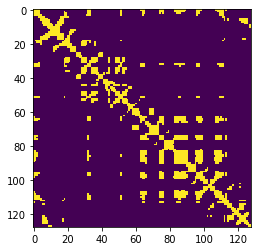

In [41]:
plt.imshow(A)

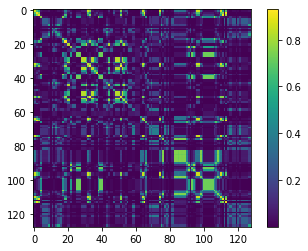

In [42]:
plt.imshow(sigmoid(Q@np.diag(np.abs(D))@Q.T + z))
plt.colorbar()

In [49]:
k =5

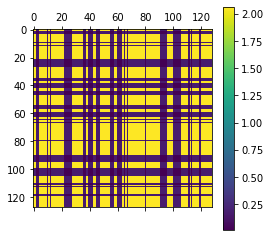

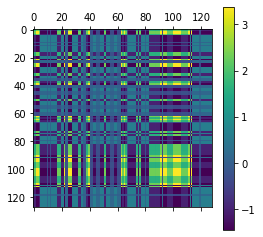

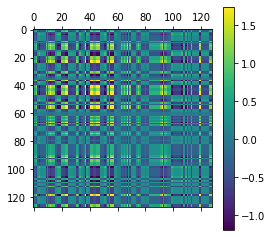

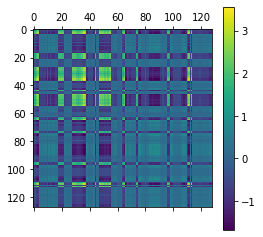

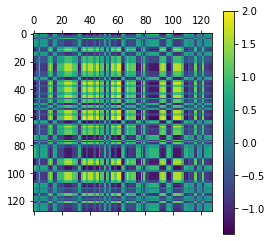

In [51]:
for i in range(k):
    q0 = np.expand_dims(Q[:,i],1)
    plt.matshow(q0@q0.T* D[i] )
    plt.colorbar()

In [52]:
D_trace = onp.array(D_trace)

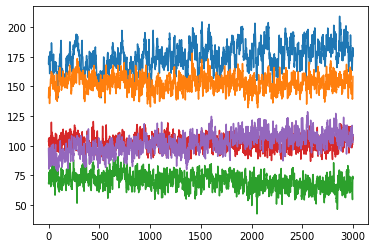

In [58]:
plt.plot(D_trace)

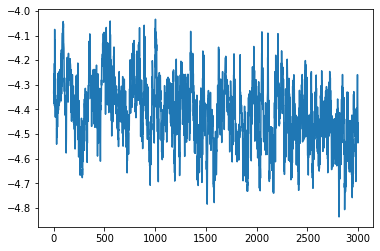

In [60]:
plt.plot(onp.array(z_trace))